## Project description
You work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans is more profitable in order to adjust the advertising budget.
You are going to carry out a preliminary analysis of the plans based on a relatively small client selection. You'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Your job is to analyze clients' behavior and determine which prepaid plan is more profitable.

## Description of the plans
Note: Megaline rounds seconds up to minutes, and megabytes to gigabytes. For calls, each individual call is rounded up: even if the call lasted just one second, it will be counted as one minute. For web traffic, individual web sessions are not rounded up. Instead, the total for the month is rounded up. If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes.
- Surf
 - Monthly charge: 20 dollars
 - 500 monthly minutes, 50 texts, and 15 GB of data
 - After exceeding the package limits:
 - 1 minute: 3 cents
 - 1 text message: 3 cents
 - 1 GB of data: 10 dollars
- Ultimate
 - Monthly charge: 70 dollars
 - 3000 monthly minutes, 1000 text messages, and 30 GB of data
 - After exceeding the package limits:
 - 1 minute: 1 cent
 - 1 text message: 1 cent
 - 1 GB of data: 7 dollars

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

# calls = pd.read_csv('megaline_calls.csv')
# web = pd.read_csv('megaline_internet.csv')
# msg = pd.read_csv('megaline_messages.csv')
# tar = pd.read_csv('megaline_tariffs.csv')
# users = pd.read_csv('megaline_users.csv')
calls = pd.read_csv('/datasets/megaline_calls.csv')
web = pd.read_csv('/datasets/megaline_internet.csv')
msg = pd.read_csv('/datasets/megaline_messages.csv')
tar = pd.read_csv('/datasets/megaline_tariffs.csv')
users = pd.read_csv('/datasets/megaline_users.csv')

In [7]:
calls['call_date'] = pd.to_datetime(calls['call_date'])

In [8]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
id           137735 non-null object
user_id      137735 non-null int64
call_date    137735 non-null datetime64[ns]
duration     137735 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


In [9]:
web['session_date'] = pd.to_datetime(web['session_date'])

In [10]:
web.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
id              104825 non-null object
user_id         104825 non-null int64
session_date    104825 non-null datetime64[ns]
mb_used         104825 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [11]:
msg['message_date'] = pd.to_datetime(msg['message_date'])

In [12]:
msg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
id              76051 non-null object
user_id         76051 non-null int64
message_date    76051 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


In [13]:
users['reg_date'] = pd.to_datetime(users['reg_date'])

In [14]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
first_name    500 non-null object
last_name     500 non-null object
age           500 non-null int64
city          500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
churn_date    34 non-null object
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


Looked at data types, converted all date entries to datetime. All other data types seem to make sense. Looks like all dataframes except tar can be combined using 'user_id', if necessary.

In [15]:
calls[calls.duplicated()]

,id,user_id,call_date,duration


In [16]:
web[web.duplicated()]

,id,user_id,session_date,mb_used


In [17]:
msg[msg.duplicated()]

,id,user_id,message_date


In [18]:
users[users.duplicated()]

,user_id,first_name,last_name,age,city,reg_date,tariff,churn_date


No duplicates found, no need to delete duplicates.

In [19]:
calls['duration'].value_counts()

0.00     26834
8.37       102
4.02       102
3.91       101
7.61       100
         ...  
25.53        1
29.34        1
26.05        1
36.24        1
27.16        1
Name: duration, Length: 2802, dtype: int64

There are a lot of 0 length call durations, this is possibly an error. At this point, would ask data engineers if these are missed calls or some other artifact skewing the data.

In [20]:
web['mb_used'].value_counts()

0.00      13747
414.46        8
435.77        8
417.46        7
313.79        7
          ...  
638.12        1
217.39        1
683.90        1
243.97        1
563.11        1
Name: mb_used, Length: 57624, dtype: int64

There are a lot of entries of 0 web usage, this should be looked into and is possibly an error, similar to the 0 duration calls.

In [21]:
users['age'].value_counts()

18    15
61    14
27    14
70    14
69    14
20    13
28    13
33    12
30    12
65    11
52    11
67    11
39    11
47    11
51    11
29    10
34    10
26    10
36    10
42    10
45    10
49    10
75    10
53    10
64    10
46    10
23     9
60     9
66     9
56     9
19     8
44     8
21     8
59     8
57     7
22     7
41     7
38     7
25     7
48     7
50     6
24     6
71     6
55     6
63     6
31     6
54     6
37     6
40     6
74     6
35     6
58     5
73     5
32     4
62     4
72     4
43     3
68     2
Name: age, dtype: int64

In [22]:
users['reg_date'].value_counts()

2018-07-12    5
2018-06-04    5
2018-11-29    5
2018-08-03    5
2018-02-06    5
             ..
2018-06-11    1
2018-01-24    1
2018-07-29    1
2018-08-29    1
2018-12-21    1
Name: reg_date, Length: 266, dtype: int64

In [23]:
users

,user_id,first_name,last_name,age,city,reg_date,tariff,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN
...,...,...,...,...,...,...,...,...
495,1495,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-04,surf,NaN
496,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,NaN
497,1497,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-10,ultimate,NaN
498,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,NaN


Almost half of the registration dates are missing. This seems to be an error. Churn dates missing imply that the user is still active in the service, but all users should have a registration date. This may not be relevant.

In [24]:
users['tariff'].value_counts()

surf        339
ultimate    161
Name: tariff, dtype: int64

In [25]:
users['city'].value_counts()

New York-Newark-Jersey City, NY-NJ-PA MSA          80
Los Angeles-Long Beach-Anaheim, CA MSA             29
Dallas-Fort Worth-Arlington, TX MSA                21
Chicago-Naperville-Elgin, IL-IN-WI MSA             19
Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA    17
                                                   ..
Albany-Schenectady-Troy, NY MSA                     1
Oxnard-Thousand Oaks-Ventura, CA MSA                1
Greensboro-High Point, NC MSA                       1
Jacksonville, FL MSA                                1
Cape Coral-Fort Myers, FL MSA                       1
Name: city, Length: 73, dtype: int64

All other data seems to be error-free.

In [26]:
calls[calls['call_date'].dt.year == 2018]

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22
...,...,...,...,...
137730,1499_199,1499,2018-11-21,8.72
137731,1499_200,1499,2018-10-20,10.89
137732,1499_201,1499,2018-09-21,8.12
137733,1499_202,1499,2018-10-10,0.37


All calls fall into 2018, so we can sort calls specifically by month by user.

In [27]:
calls['month'] = calls['call_date'].dt.month
calls

,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,8.52,12
1,1000_145,1000,2018-12-27,13.66,12
2,1000_247,1000,2018-12-27,14.48,12
3,1000_309,1000,2018-12-28,5.76,12
4,1000_380,1000,2018-12-30,4.22,12
...,...,...,...,...,...
137730,1499_199,1499,2018-11-21,8.72,11
137731,1499_200,1499,2018-10-20,10.89,10
137732,1499_201,1499,2018-09-21,8.12,9
137733,1499_202,1499,2018-10-10,0.37,10


New column added to calls dataframe with the month each call was made.

In [28]:
users_callspermonth = calls.groupby(['user_id', 'month'])['duration'].count()
users_callspermonth

user_id  month
1000     12       16
1001     8        27
         9        49
         10       65
         11       64
                  ..
1498     12       39
1499     9        41
         10       53
         11       45
         12       65
Name: duration, Length: 2258, dtype: int64

In [29]:
users_minpermonth = calls.groupby(['user_id', 'month'])['duration'].sum()
users_minpermonth

user_id  month
1000     12       116.83
1001     8        171.14
         9        297.69
         10       374.11
         11       404.59
                   ...  
1498     12       324.77
1499     9        330.37
         10       363.28
         11       288.56
         12       468.10
Name: duration, Length: 2258, dtype: float64

Dataframes created for calls per month and minutes used per users per month.

In [30]:
msg['month'] = msg['message_date'].dt.month
msg['month'].value_counts()

12    19071
11    14068
10    12201
9      9227
8      7394
7      5208
6      3833
5      2780
4      1333
3       594
2       259
1        83
Name: month, dtype: int64

In [31]:
users_msgpermonth = msg.groupby(['user_id', 'month'])['message_date'].count()
users_msgpermonth

user_id  month
1000     12       11
1001     8        30
         9        44
         10       53
         11       36
                  ..
1496     9        21
         10       18
         11       13
         12       11
1497     12       50
Name: message_date, Length: 1806, dtype: int64

Number of messages sent per user per month put into a new dataframe.

In [32]:
web['month'] = web['session_date'].dt.month
web['month'].value_counts()

12    23492
11    18651
10    16193
9     12722
8     10718
7      8110
6      6057
5      4288
4      2558
3      1336
2       604
1        96
Name: month, dtype: int64

In [33]:
users_mbpermonth = web.groupby(['user_id', 'month'])['mb_used'].sum()
users_mbpermonth

user_id  month
1000     12        1901.47
1001     8         6919.15
         9        13314.82
         10       22330.49
         11       18504.30
                    ...   
1498     12       23137.69
1499     9        12984.76
         10       19492.43
         11       16813.83
         12       22059.21
Name: mb_used, Length: 2277, dtype: float64

Dataframe created with MB used per user per month.

In [34]:
users_callspermonth = users_callspermonth.reset_index()
users_minpermonth = users_minpermonth.reset_index()
users_msgpermonth = users_msgpermonth.reset_index()
users_mbpermonth = users_mbpermonth.reset_index()

users_callspermonth.set_index(['user_id', 'month'], inplace=True)
users_minpermonth.set_index(['user_id', 'month'], inplace=True)
users_msgpermonth.set_index(['user_id', 'month'], inplace=True)
users_mbpermonth.set_index(['user_id', 'month'], inplace=True)

In [35]:
users_callspermonth.rename(columns={'duration' : 'call_count'}, inplace=True)
users_minpermonth.rename(columns={'duration' : 'minutes'}, inplace=True)
users_msgpermonth.rename(columns={'message_date' : 'msg_count'}, inplace=True)


In [36]:
user_month_data = pd.concat([users_callspermonth, users_minpermonth, users_msgpermonth, users_mbpermonth], axis=1)
user_month_data['id'] = user_month_data.index.get_level_values(0)
user_month_data

call_count  minutes  msg_count   mb_used    id
user_id month                                                
1000    12           16.0   116.83       11.0   1901.47  1000
1001    8            27.0   171.14       30.0   6919.15  1001
        9            49.0   297.69       44.0  13314.82  1001
        10           65.0   374.11       53.0  22330.49  1001
        11           64.0   404.59       36.0  18504.30  1001
...                   ...      ...        ...       ...   ...
1498    12           39.0   324.77        NaN  23137.69  1498
1499    9            41.0   330.37        NaN  12984.76  1499
        10           53.0   363.28        NaN  19492.43  1499
        11           45.0   288.56        NaN  16813.83  1499
        12           65.0   468.10        NaN  22059.21  1499

[2293 rows x 5 columns]

In [37]:
user_month_data.query('user_id == 1140 and month == 8')

,,call_count,minutes,msg_count,mb_used,id
user_id,month,,,,,
1140,8,89.0,542.74,13.0,20653.77,1140


Making sure users can be queried from user_month_data properly. All seems to be correct.

Combined all user info into one dataframe grouped by user_id and month.

In [38]:
users

,user_id,first_name,last_name,age,city,reg_date,tariff,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN
...,...,...,...,...,...,...,...,...
495,1495,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-04,surf,NaN
496,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,NaN
497,1497,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-10,ultimate,NaN
498,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,NaN


In [39]:
plan_key = users[['user_id', 'tariff']].set_index('user_id')
plan_key = plan_key['tariff']
user_dict = plan_key.to_dict()
user_dict

{1000: 'ultimate',
 1001: 'surf',
 1002: 'surf',
 1003: 'surf',
 1004: 'surf',
 1005: 'surf',
 1006: 'ultimate',
 1007: 'surf',
 1008: 'ultimate',
 1009: 'surf',
 1010: 'surf',
 1011: 'ultimate',
 1012: 'surf',
 1013: 'ultimate',
 1014: 'surf',
 1015: 'surf',
 1016: 'surf',
 1017: 'surf',
 1018: 'surf',
 1019: 'surf',
 1020: 'surf',
 1021: 'surf',
 1022: 'surf',
 1023: 'surf',
 1024: 'surf',
 1025: 'ultimate',
 1026: 'ultimate',
 1027: 'surf',
 1028: 'ultimate',
 1029: 'surf',
 1030: 'ultimate',
 1031: 'ultimate',
 1032: 'ultimate',
 1033: 'ultimate',
 1034: 'surf',
 1035: 'surf',
 1036: 'ultimate',
 1037: 'ultimate',
 1038: 'ultimate',
 1039: 'ultimate',
 1040: 'surf',
 1041: 'ultimate',
 1042: 'surf',
 1043: 'ultimate',
 1044: 'surf',
 1045: 'surf',
 1046: 'surf',
 1047: 'ultimate',
 1048: 'surf',
 1049: 'surf',
 1050: 'ultimate',
 1051: 'surf',
 1052: 'surf',
 1053: 'surf',
 1054: 'surf',
 1055: 'surf',
 1056: 'surf',
 1057: 'ultimate',
 1058: 'surf',
 1059: 'ultimate',
 1060: 'surf

In [40]:
tar

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,tariff_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [41]:
def month_profit(row):
    if user_dict[row['id']] == 'surf':
        surf_msg = (row['msg_count'] - tar.at[0, 'messages_included'])
        if surf_msg > 0:
            surf_msg_charge = (surf_msg * tar.at[0, 'usd_per_message'])
        else:
            surf_msg_charge = 0
        surf_mb = (row['mb_used'] - tar.at[0, 'mb_per_month_included'])
        if surf_mb > 0:
            surf_mb_charge = ((surf_mb*.001) * tar.at[0, 'usd_per_gb'])
        else:
            surf_mb_charge = 0
        surf_min = (row['minutes'] - tar.at[0, 'minutes_included'])
        if surf_min > 0:
            surf_min_charge = (surf_min * tar.at[0, 'usd_per_minute'])
        else:
            surf_min_charge = 0
        surf_cost_month = (tar.at[0, 'usd_monthly_pay'] + surf_msg_charge + surf_mb_charge + surf_min_charge)
        return surf_cost_month
        
    else:
        ult_msg = (row['msg_count'] - tar.at[1, 'messages_included'])
        if ult_msg > 0:
            ult_msg_charge = (ult_msg * tar.at[1, 'usd_per_message'])
        else:
            ult_msg_charge = 0
        ult_mb = (row['mb_used'] - tar.at[1, 'mb_per_month_included'])
        if ult_mb > 0:
            ult_mb_charge = ((ult_mb*.001) * tar.at[1, 'usd_per_gb'])
        else:
            ult_mb_charge = 0
        ult_min = (row['minutes'] - tar.at[1, 'minutes_included'])
        if ult_min > 0:
            ult_min_charge = (ult_min * tar.at[1, 'usd_per_minute'])
        else:
            ult_min_charge = 0
        ult_cost_month = (tar.at[1, 'usd_monthly_pay'] + ult_msg_charge + ult_mb_charge + ult_min_charge)
        return ult_cost_month
user_month_data['profit'] = user_month_data.apply(month_profit, axis=1)
user_month_data

call_count  minutes  msg_count   mb_used    id   profit
user_id month                                                         
1000    12           16.0   116.83       11.0   1901.47  1000  70.0000
1001    8            27.0   171.14       30.0   6919.15  1001  20.0000
        9            49.0   297.69       44.0  13314.82  1001  20.0000
        10           65.0   374.11       53.0  22330.49  1001  89.7949
        11           64.0   404.59       36.0  18504.30  1001  51.4430
...                   ...      ...        ...       ...   ...      ...
1498    12           39.0   324.77        NaN  23137.69  1498  97.7769
1499    9            41.0   330.37        NaN  12984.76  1499  20.0000
        10           53.0   363.28        NaN  19492.43  1499  61.3243
        11           45.0   288.56        NaN  16813.83  1499  34.5383
        12           65.0   468.10        NaN  22059.21  1499  86.9921

[2293 rows x 6 columns]

Function created to determine profit from each user per month based on plan and usage.

In [42]:
def plan_name(row):
    return user_dict[row['id']]
user_month_data['plan'] = user_month_data.apply(plan_name, axis=1)
user_month_data

call_count  minutes  msg_count   mb_used    id   profit  \
user_id month                                                            
1000    12           16.0   116.83       11.0   1901.47  1000  70.0000   
1001    8            27.0   171.14       30.0   6919.15  1001  20.0000   
        9            49.0   297.69       44.0  13314.82  1001  20.0000   
        10           65.0   374.11       53.0  22330.49  1001  89.7949   
        11           64.0   404.59       36.0  18504.30  1001  51.4430   
...                   ...      ...        ...       ...   ...      ...   
1498    12           39.0   324.77        NaN  23137.69  1498  97.7769   
1499    9            41.0   330.37        NaN  12984.76  1499  20.0000   
        10           53.0   363.28        NaN  19492.43  1499  61.3243   
        11           45.0   288.56        NaN  16813.83  1499  34.5383   
        12           65.0   468.10        NaN  22059.21  1499  86.9921   

                   plan  
user_id month            
1000    12     ultimate  
1001    8          surf  
        9          surf  
        10         surf  
        11         surf  
...                 ...  
1498    12         surf  
1499    9          surf  
        10         surf  
        11         surf  
        12         surf  

[2293 rows x 7 columns]

In [43]:
surf_users = user_month_data[user_month_data['plan'] == 'surf']
ult_users = user_month_data[user_month_data['plan'] == 'ultimate']

In [44]:
surf_stats = surf_users.reset_index().pivot('user_id','month').describe()
surf_stats

call_count                                                             \
month         1           2           3          4           5           6    
count   2.000000    9.000000   23.000000   50.00000   75.000000   96.000000   
mean   30.000000   40.666667   46.434783   48.88000   57.186667   60.093750   
std    16.970563   28.262166   26.391848   29.61635   33.114745   28.120447   
min    18.000000    7.000000    5.000000    3.00000    2.000000    2.000000   
25%    24.000000   31.000000   32.500000   23.75000   33.500000   41.750000   
50%    30.000000   37.000000   49.000000   47.00000   58.000000   61.000000   
75%    36.000000   42.000000   56.500000   71.00000   77.500000   78.000000   
max    42.000000  106.000000  116.000000  129.00000  150.000000  138.000000   

                                                       ...      profit  \
month          7           8           9           10  ...          3    
count  120.000000  159.000000  191.000000  232.000000  ...   23.000000   
mean    63.683333   58.647799   59.020942   61.650862  ...   44.130930   
std     33.298998   31.658410   29.539618   30.632490  ...   38.287686   
min      2.000000    1.000000    1.000000    1.000000  ...   20.000000   
25%     43.000000   39.500000   39.000000   39.750000  ...   20.000000   
50%     65.000000   56.000000   59.000000   62.000000  ...   20.000000   
75%     81.000000   77.500000   77.000000   80.000000  ...   55.480700   
max    164.000000  161.000000  180.000000  162.000000  ...  169.877600   

                                                                               \
month          4           5           6           7           8           9    
count   50.000000   77.000000   97.000000  121.000000  162.000000  194.000000   
mean    39.207632   45.921403   46.509030   60.065990   61.590359   55.730676   
std     33.833857   43.432752   43.712367   53.966512   59.881357   46.876871   
min     20.000000   20.000000   20.000000   20.000000   20.000000   20.000000   
25%     20.000000   20.000000   20.000000   20.030000   20.000000   20.000000   
50%     20.000000   20.849600   23.538200   37.443000   36.956900   37.070000   
75%     45.684725   70.294000   52.708700   82.487700   82.632825   76.340575   
max    151.498000  233.984200  237.427700  255.690900  384.493500  240.160200   

                                           
month          10          11          12  
count  237.000000  283.000000  318.000000  
mean    62.605880   55.732373   67.415749  
std     55.921621   49.421314   68.031960  
min     20.000000   20.000000   20.000000  
25%     20.000000   20.000000   22.397225  
50%     43.906600   36.090800   46.936150  
75%     82.488200   74.070400   86.127575  
max    335.087500  295.421000  594.353100  

[8 rows x 72 columns]

In [45]:
ult_stats = ult_users.reset_index().pivot('user_id', 'month').describe()
ult_stats

call_count                                                              \
month         1           2           3           4           5           6    
count   4.000000    6.000000   12.000000   21.000000   29.000000   45.000000   
mean   28.000000   68.000000   46.000000   47.523810   57.586207   54.488889   
std    17.757627   33.250564   37.421433   26.991886   29.382353   27.068618   
min     5.000000   11.000000    4.000000    7.000000    3.000000    6.000000   
25%    18.500000   61.500000   14.750000   29.000000   39.000000   32.000000   
50%    32.500000   70.500000   36.000000   49.000000   58.000000   57.000000   
75%    42.000000   82.500000   70.250000   60.000000   79.000000   73.000000   
max    42.000000  111.000000  107.000000  104.000000  113.000000  116.000000   

                                                       ...      profit  \
month          7           8           9           10  ...          3    
count   59.000000   71.000000   86.000000  105.000000  ...   12.000000   
mean    58.694915   60.070423   61.046512   64.390476  ...   73.473867   
std     37.506438   32.815207   32.227101   32.258718  ...   10.713906   
min      3.000000    4.000000    6.000000    5.000000  ...   70.000000   
25%     30.500000   35.000000   36.000000   39.000000  ...   70.000000   
50%     62.000000   60.000000   61.000000   67.000000  ...   70.000000   
75%     78.000000   78.000000   75.750000   82.000000  ...   70.421663   
max    166.000000  182.000000  168.000000  175.000000  ...  107.387280   

                                                                              \
month          4          5           6           7           8           9    
count   21.000000  29.000000   47.000000   59.000000   71.000000   86.000000   
mean    72.837890  70.528097   71.512427   71.894824   72.744425   71.855805   
std     10.878128   2.843889    7.878353   10.203643   11.983250    8.009108   
min     70.000000  70.000000   70.000000   70.000000   70.000000   70.000000   
25%     70.000000  70.000000   70.000000   70.000000   70.000000   70.000000   
50%     70.000000  70.000000   70.000000   70.000000   70.000000   70.000000   
75%     70.000000  70.000000   70.000000   70.000000   70.000000   70.000000   
max    119.291130  85.314810  120.309980  126.746900  137.677470  118.069210   

                                           
month          10          11          12  
count  106.000000  127.000000  151.000000  
mean    72.141890   71.639633   73.118812  
std     12.610416    9.488731   14.317220  
min     70.000000   70.000000   70.000000  
25%     70.000000   70.000000   70.000000  
50%     70.000000   70.000000   70.000000  
75%     70.000000   70.000000   70.000000  
max    181.127310  155.628130  178.468570  

[8 rows x 72 columns]

In [46]:
ult_stats.loc[:,('call_count', 3)]

count     12.000000
mean      46.000000
std       37.421433
min        4.000000
25%       14.750000
50%       36.000000
75%       70.250000
max      107.000000
Name: (call_count, 3), dtype: float64

Descriptive statistics found for each plan, per variable, per month.

In [47]:
ult_month = ult_users.groupby('month').sum()
ult_month

,call_count,minutes,msg_count,mb_used,id,profit
month,,,,,,
1,112.0,732.65,62.0,27672.37,4672,280.00000
2,408.0,2659.03,151.0,119901.66,8101,490.00000
3,552.0,3428.42,243.0,219858.22,14102,881.68640
4,998.0,6646.67,463.0,338554.75,25101,1529.59569
5,1670.0,11126.28,931.0,482109.99,35537,2045.31481
6,2452.0,16441.12,1379.0,720882.29,58196,3361.08409
7,3463.0,23822.27,1937.0,964339.92,73714,4241.79462
8,4265.0,28206.51,2732.0,1264845.13,89517,5164.85417
9,5250.0,35542.71,3259.0,1459408.78,108845,6179.59923


In [48]:
surf_month = surf_users.groupby('month').sum()
surf_month

,call_count,minutes,msg_count,mb_used,id,profit
month,,,,,,
1,60.0,385.68,21.0,9749.72,2404,40.0000
2,366.0,2527.66,108.0,109609.59,11338,299.6450
3,1068.0,7152.31,351.0,306945.12,29228,1015.0114
4,2444.0,16619.00,870.0,599210.15,62439,1960.3816
5,4289.0,29033.10,1849.0,1073099.33,95348,3535.9480
6,5769.0,39499.26,2454.0,1484248.33,119822,4511.3759
7,7642.0,51367.31,3271.0,2030815.67,148939,7267.9848
8,9325.0,62721.48,4662.0,2720843.68,199675,9977.6382
9,11273.0,75852.46,5968.0,3218737.67,241472,10811.7512


In [49]:
by_month = pd.merge(surf_month[['call_count', 'minutes', 'msg_count', 'mb_used', 'profit']], ult_month[['call_count', 'minutes', 'msg_count', 'mb_used', 'profit']], on='month', suffixes=('_surf', '_ult'))
by_month

,call_count_surf,minutes_surf,msg_count_surf,mb_used_surf,profit_surf,call_count_ult,minutes_ult,msg_count_ult,mb_used_ult,profit_ult
month,,,,,,,,,,
1,60.0,385.68,21.0,9749.72,40.0000,112.0,732.65,62.0,27672.37,280.00000
2,366.0,2527.66,108.0,109609.59,299.6450,408.0,2659.03,151.0,119901.66,490.00000
3,1068.0,7152.31,351.0,306945.12,1015.0114,552.0,3428.42,243.0,219858.22,881.68640
4,2444.0,16619.00,870.0,599210.15,1960.3816,998.0,6646.67,463.0,338554.75,1529.59569
5,4289.0,29033.10,1849.0,1073099.33,3535.9480,1670.0,11126.28,931.0,482109.99,2045.31481
6,5769.0,39499.26,2454.0,1484248.33,4511.3759,2452.0,16441.12,1379.0,720882.29,3361.08409
7,7642.0,51367.31,3271.0,2030815.67,7267.9848,3463.0,23822.27,1937.0,964339.92,4241.79462
8,9325.0,62721.48,4662.0,2720843.68,9977.6382,4265.0,28206.51,2732.0,1264845.13,5164.85417
9,11273.0,75852.46,5968.0,3218737.67,10811.7512,5250.0,35542.71,3259.0,1459408.78,6179.59923


Statistics per plan merged into one dataframe for easier comparison.

Text(0.5, 1.0, 'Call Counts per Month by Plan')

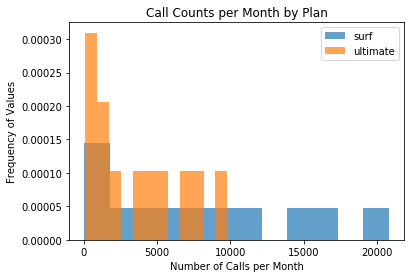

In [50]:
plt.hist(by_month['call_count_surf'], density=True, alpha=.7, bins=12)
plt.hist(by_month['call_count_ult'], density=True, alpha=.7, bins=12)
plt.legend(['surf', 'ultimate'])
plt.xlabel('Number of Calls per Month')
plt.ylabel('Frequency of Values')
plt.title('Call Counts per Month by Plan')

Text(0.5, 1.0, 'Minutes Used per Month by Plan')

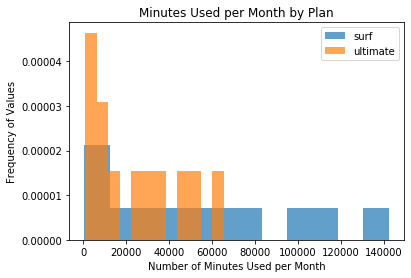

In [51]:
plt.hist(by_month['minutes_surf'], density=True, alpha=.7, bins=12)
plt.hist(by_month['minutes_ult'], density=True, alpha=.7, bins=12)
plt.legend(['surf', 'ultimate'])
plt.xlabel('Number of Minutes Used per Month')
plt.ylabel('Frequency of Values')
plt.title('Minutes Used per Month by Plan')

Text(0.5, 1.0, 'Messages Sent per Month by Plan')

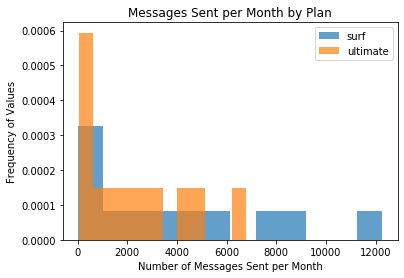

In [52]:
plt.hist(by_month['msg_count_surf'], density=True, alpha=.7, bins=12)
plt.hist(by_month['msg_count_ult'], density=True, alpha=.7, bins=12)
plt.legend(['surf', 'ultimate'])
plt.xlabel('Number of Messages Sent per Month')
plt.ylabel('Frequency of Values')
plt.title('Messages Sent per Month by Plan')

Text(0.5, 1.0, 'MB Used per Month by Plan')

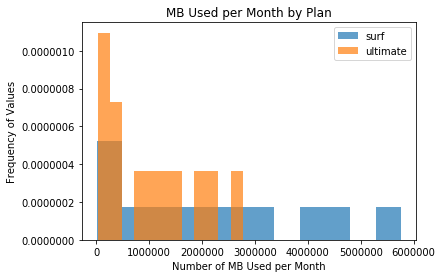

In [53]:
plt.hist(by_month['mb_used_surf'], density=True, alpha=.7, bins=12)
plt.hist(by_month['mb_used_ult'], density=True, alpha=.7, bins=12)
plt.legend(['surf', 'ultimate'])
plt.xlabel('Number of MB Used per Month')
plt.ylabel('Frequency of Values')
plt.title('MB Used per Month by Plan')

Text(0.5, 1.0, 'Profit per Month by Plan')

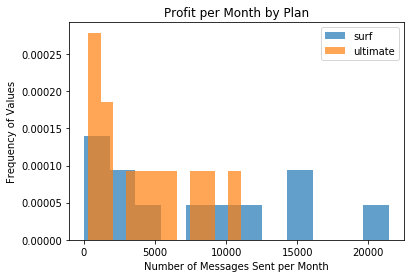

In [54]:
plt.hist(by_month['profit_surf'], density=True, alpha=.7, bins=12)
plt.hist(by_month['profit_ult'], density=True, alpha=.7, bins=12)
plt.legend(['surf', 'ultimate'])
plt.xlabel('Number of Messages Sent per Month')
plt.ylabel('Frequency of Values')
plt.title('Profit per Month by Plan')

In [55]:
by_month['profit_surf'].sum()

91467.79930000001

In [56]:
by_month['profit_ult'].sum()

51960.143200000006

Overall, surf users have a tendency to use more of everything, calls, minutes, messages, and MB. This results in the surf plan also offering a higher profit. Ultimate users, despite having a higher 'free limit' and lower overage fees, tend to use less aspects of the plans. People probably tend to opt for the cheaper plan up front, but end up paying more in the long run. Offering the surf plan is a good idea because it turns over the larger profit.

In [57]:
surf_users['profit'].mean()

58.148632739987285

In [58]:
ult_users['profit'].mean()

72.16686555555556

In [59]:
surf_users.describe()

,call_count,minutes,msg_count,mb_used,id,profit
count,1545.000000,1545.000000,1222.000000,1558.000000,1573.000000,1573.000000
mean,60.895793,412.097890,40.109656,16717.702137,1242.755245,58.148633
std,31.268044,216.797727,33.035500,7884.682983,139.227939,55.003591
min,1.000000,0.000000,1.000000,92.310000,1001.000000,20.000000
25%,40.000000,262.780000,16.000000,12187.955000,1120.000000,20.000000
50%,60.000000,405.710000,32.000000,16923.830000,1245.000000,36.889900
75%,80.000000,546.230000,54.000000,21039.860000,1358.000000,78.177100
max,205.000000,1431.220000,266.000000,70931.590000,1499.000000,594.353100


In [60]:
ult_users.describe()

,call_count,minutes,msg_count,mb_used,id,profit
count,713.000000,713.000000,584.000000,719.000000,720.000000,720.000000
mean,61.221599,410.180954,46.296233,17238.642253,1253.330556,72.166866
std,32.855296,224.745705,32.942118,7831.018323,150.915644,11.027300
min,2.000000,0.000000,1.000000,233.170000,1000.000000,70.000000
25%,37.000000,247.970000,21.000000,12671.130000,1126.000000,70.000000
50%,61.000000,399.980000,41.000000,16863.450000,1241.500000,70.000000
75%,80.000000,534.820000,66.000000,21025.155000,1401.000000,70.000000
max,191.000000,1292.090000,166.000000,46595.330000,1497.000000,181.127310


In [61]:
alpha = .05
profit_results = st.ttest_ind(surf_users['profit'], ult_users['profit'])
profit_results

Ttest_indResult(statistic=-6.775812286349983, pvalue=1.5676556885188408e-11)

In [62]:
profit_results.pvalue < alpha

True

The p-value of an independent t-test between the average profits of the surf and ultimate plans is less than .05, which means that we reject the null hypothesis that there is no statistical difference between the profits of the two plans. There is a provable statistical difference between the amounts of profit for each plan.

I used a bilateral t-test because we are looking for any difference, regardless of direction, between the plans. The null hypothesis means there is 'no change', which would be that there is no difference between profits for the plans.

In [63]:
city_key = users.set_index('user_id')['city'].to_dict()
city_key

{1000: 'Atlanta-Sandy Springs-Roswell, GA MSA',
 1001: 'Seattle-Tacoma-Bellevue, WA MSA',
 1002: 'Las Vegas-Henderson-Paradise, NV MSA',
 1003: 'Tulsa, OK MSA',
 1004: 'Seattle-Tacoma-Bellevue, WA MSA',
 1005: 'Dallas-Fort Worth-Arlington, TX MSA',
 1006: 'San Francisco-Oakland-Berkeley, CA MSA',
 1007: 'Grand Rapids-Kentwood, MI MSA',
 1008: 'Orlando-Kissimmee-Sanford, FL MSA',
 1009: 'San Jose-Sunnyvale-Santa Clara, CA MSA',
 1010: 'Dallas-Fort Worth-Arlington, TX MSA',
 1011: 'Cleveland-Elyria, OH MSA',
 1012: 'Chicago-Naperville-Elgin, IL-IN-WI MSA',
 1013: 'Knoxville, TN MSA',
 1014: 'New York-Newark-Jersey City, NY-NJ-PA MSA',
 1015: 'Pittsburgh, PA MSA',
 1016: 'Fresno, CA MSA',
 1017: 'Washington-Arlington-Alexandria, DC-VA-MD-WV MSA',
 1018: 'Indianapolis-Carmel-Anderson, IN MSA',
 1019: 'Jacksonville, FL MSA',
 1020: 'Dallas-Fort Worth-Arlington, TX MSA',
 1021: 'Los Angeles-Long Beach-Anaheim, CA MSA',
 1022: 'New York-Newark-Jersey City, NY-NJ-PA MSA',
 1023: 'Omaha-Council

In [64]:
user_month_data['city'] = user_month_data['id'].map(city_key)
user_month_data

call_count  minutes  msg_count   mb_used    id   profit  \
user_id month                                                            
1000    12           16.0   116.83       11.0   1901.47  1000  70.0000   
1001    8            27.0   171.14       30.0   6919.15  1001  20.0000   
        9            49.0   297.69       44.0  13314.82  1001  20.0000   
        10           65.0   374.11       53.0  22330.49  1001  89.7949   
        11           64.0   404.59       36.0  18504.30  1001  51.4430   
...                   ...      ...        ...       ...   ...      ...   
1498    12           39.0   324.77        NaN  23137.69  1498  97.7769   
1499    9            41.0   330.37        NaN  12984.76  1499  20.0000   
        10           53.0   363.28        NaN  19492.43  1499  61.3243   
        11           45.0   288.56        NaN  16813.83  1499  34.5383   
        12           65.0   468.10        NaN  22059.21  1499  86.9921   

                   plan                                       city  
user_id month                                                       
1000    12     ultimate      Atlanta-Sandy Springs-Roswell, GA MSA  
1001    8          surf            Seattle-Tacoma-Bellevue, WA MSA  
        9          surf            Seattle-Tacoma-Bellevue, WA MSA  
        10         surf            Seattle-Tacoma-Bellevue, WA MSA  
        11         surf            Seattle-Tacoma-Bellevue, WA MSA  
...                 ...                                        ...  
1498    12         surf  New York-Newark-Jersey City, NY-NJ-PA MSA  
1499    9          surf          Orlando-Kissimmee-Sanford, FL MSA  
        10         surf          Orlando-Kissimmee-Sanford, FL MSA  
        11         surf          Orlando-Kissimmee-Sanford, FL MSA  
        12         surf          Orlando-Kissimmee-Sanford, FL MSA  

[2293 rows x 8 columns]

In [65]:
NYNJusers = user_month_data.loc[(user_month_data['city'].str.contains('NY-NJ'))]
NYNJusers

call_count  minutes  msg_count   mb_used    id    profit  plan  \
user_id month                                                                   
1014    11           28.0   149.33        9.0   1175.59  1014   20.0000  surf   
        12          150.0  1050.62       64.0   7792.41  1014   36.9386  surf   
1022    5            39.0   287.34        NaN   4908.08  1022   20.0000  surf   
        6            76.0   455.45        NaN  23436.48  1022  100.7648  surf   
        7            70.0   448.25        NaN   9933.15  1022   20.0000  surf   
...                   ...      ...        ...       ...   ...       ...   ...   
1498    8            44.0   244.57        NaN  20261.89  1498   69.0189  surf   
        9            45.0   344.62        NaN  22827.28  1498   94.6728  surf   
        10           46.0   278.06        NaN  20580.76  1498   72.2076  surf   
        11           41.0   208.99        NaN  19168.55  1498   58.0855  surf   
        12           39.0   324.77        NaN  23137.69  1498   97.7769  surf   

                                                    city  
user_id month                                             
1014    11     New York-Newark-Jersey City, NY-NJ-PA MSA  
        12     New York-Newark-Jersey City, NY-NJ-PA MSA  
1022    5      New York-Newark-Jersey City, NY-NJ-PA MSA  
        6      New York-Newark-Jersey City, NY-NJ-PA MSA  
        7      New York-Newark-Jersey City, NY-NJ-PA MSA  
...                                                  ...  
1498    8      New York-Newark-Jersey City, NY-NJ-PA MSA  
        9      New York-Newark-Jersey City, NY-NJ-PA MSA  
        10     New York-Newark-Jersey City, NY-NJ-PA MSA  
        11     New York-Newark-Jersey City, NY-NJ-PA MSA  
        12     New York-Newark-Jersey City, NY-NJ-PA MSA  

[377 rows x 8 columns]

In [66]:
otherusers = user_month_data.loc[~(user_month_data['city'].str.contains('NY-NJ'))]
otherusers

call_count  minutes  msg_count   mb_used    id   profit  \
user_id month                                                            
1000    12           16.0   116.83       11.0   1901.47  1000  70.0000   
1001    8            27.0   171.14       30.0   6919.15  1001  20.0000   
        9            49.0   297.69       44.0  13314.82  1001  20.0000   
        10           65.0   374.11       53.0  22330.49  1001  89.7949   
        11           64.0   404.59       36.0  18504.30  1001  51.4430   
...                   ...      ...        ...       ...   ...      ...   
1497    12           54.0   276.53       50.0  11106.55  1497  70.0000   
1499    9            41.0   330.37        NaN  12984.76  1499  20.0000   
        10           53.0   363.28        NaN  19492.43  1499  61.3243   
        11           45.0   288.56        NaN  16813.83  1499  34.5383   
        12           65.0   468.10        NaN  22059.21  1499  86.9921   

                   plan                                    city  
user_id month                                                    
1000    12     ultimate   Atlanta-Sandy Springs-Roswell, GA MSA  
1001    8          surf         Seattle-Tacoma-Bellevue, WA MSA  
        9          surf         Seattle-Tacoma-Bellevue, WA MSA  
        10         surf         Seattle-Tacoma-Bellevue, WA MSA  
        11         surf         Seattle-Tacoma-Bellevue, WA MSA  
...                 ...                                     ...  
1497    12     ultimate  Los Angeles-Long Beach-Anaheim, CA MSA  
1499    9          surf       Orlando-Kissimmee-Sanford, FL MSA  
        10         surf       Orlando-Kissimmee-Sanford, FL MSA  
        11         surf       Orlando-Kissimmee-Sanford, FL MSA  
        12         surf       Orlando-Kissimmee-Sanford, FL MSA  

[1916 rows x 8 columns]

In [67]:
NYNJusers['profit'].mean()

57.84940583554377

In [68]:
otherusers['profit'].mean()

63.475321764091866

In [69]:
NYNJ_results = st.ttest_ind(NYNJusers['profit'], otherusers['profit'])
NYNJ_results

Ttest_indResult(statistic=-2.1524309787360565, pvalue=0.03146757549710085)

In [70]:
NYNJ_results.pvalue < alpha

True

The p-value of an independent t-test between the profit of NY/NJ users and all other users is indeed different. We reject the null hypothesis of no difference between the two sources. The profit from the users is independent because it is based on location of users.

Once again, a bilateral t-test was used because we are looking to see if there is any difference between values.

# Overall Conclusion

The most dramatic conclusion we can draw from this data is that the marketing plan of having both a 'budget' and 'unlimited' plan works very well for the company. The 'budget' plan offers a larger mean income than the 'unlimited' one, despite the lower entrance cost. It is possible that many customers underestimate their actual usage, and feel as if they are paying less with a lower flat rate and only paying minor overages. Ultimate users tend to have lower actual usage, despite paying more up front. Perhaps the ultimate users are more cautious, anticipating the need for more usage, and being scrupulous in use anyways.

Most of the probability distributions follow a Poisson distribution, which makes sense for the data observed. The values recorded cannot be found less than 0, as you cannot make a negative amount of calls. This implies a basically normal distribution among all the variables per plan.

Because these distributions are fairly close to each other in the graphs, it is useful to use an independent t-test to statistically prove differences between situations. Above, we compare the difference in overall profit between plans, and then also between NY/NJ residents and the rest of the dataset. Both show that there is a definable difference between the means of each grouping. In both situations, the characteristics being tested against each other is independent of the other.

Looking at all of the data available to us, it appears that it may be a good idea to implement an even more 'budget' option, possibly pay-as-you-go. Customers seem to prefer a lower barrier to entry (monthly fee), and costs can be recovered in overage prices.
Additionally, from the initial look at profit by area, this information could be used to help the marketing department figure out where to focus ad campaigns. Areas that are not participating as much might need more advertising, or perhaps there is a reason that potential customers are not using the plan. For that, considering the means of users per population might reveal more than simply analyzing the profit.